In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [2]:
data = pd.read_csv("data/NORMAL+EDLC(5%-(40-4-10)_4).csv").iloc[:, :3]

### 기준 전압 인덱스 구하기

휴지구간 찾기

In [3]:
comm_A = np.where(data['Current(A)'] == 0)[0]

5% 소모 후 휴지 시작하는 인덱스

In [4]:
#첫 번째 인덱스는 넣어두고 시작
dead_80_ = np.array(comm_A[0])

for idx in range(comm_A.shape[0]-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_A[idx]+1 != comm_A[idx+1]:
        dead_80_ = np.append(dead_80_, comm_A[idx+1])

In [5]:
dead_80 = np.array([], dtype=int)

for i in range(0, len(dead_80_), 2):
    dead_80 = np.append(dead_80, np.array(dead_80_[i]))

5% 소모하기 전 기준 인덱스 구하기 (통신 끝나고 난 후 휴지 구간 마지막 인덱스)

In [25]:
#첫 번째 인덱스는 넣어두고 시작
ref_80_ = np.array([], dtype=int)

for idx in reversed(range(comm_A.shape[0]-1)):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_A[idx]+1 != comm_A[idx+1]:
        ref_80_ = np.append(ref_80_, comm_A[idx])
ref_80_ = np.flip(ref_80_)

In [26]:
ref_80 = np.array([], dtype=int)

for i in range(1, len(ref_80_), 2):
    ref_80 = np.append(ref_80, np.array(ref_80_[i]))

In [27]:
ref_80 = np.append(np.array(0), ref_80)

패턴 40mA로 시작 -> 기준 전압

In [197]:
comm_40__ = np.where((data['Current(A)'] < 0.0500) & (data['Current(A)'] > 0.030))[0] #통신 전류 -> 0.040

0.080로 5% 소모하는 구간에 0.040 전류가 끼어있음

In [198]:
comm_40__ = np.delete(comm_40__, np.where(comm_40__ == 590501))

#### 통신 전류 시작 인덱스 하나만

In [199]:
#첫 번째 인덱스는 넣어두고 시작
comm_40_ = np.array(comm_40__[0])

for idx in range(comm_40__.shape[0]-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_40__[idx]+1 != comm_40__[idx+1]:
        comm_40_ = np.append(comm_40_, comm_40__[idx+1])

In [200]:
comm_40 = np.array([], dtype=int)

for i in range(0, len(comm_40_), 4):
    comm_40 = np.append(comm_40, np.array(comm_40_[i]))

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [204]:
t_crit = comm_40 - 1

4mA 인덱스 찾기

In [207]:
comm_4_ = np.where((data['Current(A)'] > 0) & (data['Current(A)'] < 0.0050))[0]

연속된 인덱스 제거 -> 첫번째 인덱스만

In [208]:
#첫 번째 인덱스는 넣어두고 시작
comm_4 = np.array(comm_4_[0])

for idx in range(comm_4_.shape[0]-1):
    #현재 값+1과 다음값이 같지 않으면 연속된 숫자가 아니라는 것으로 추가함
    if comm_4_[idx]+1 != comm_4_[idx+1]:
        comm_4 = np.append(comm_4, comm_4_[idx+1])

In [260]:
ref_4 = np.array([], dtype=int)

for i in range(1, len(comm_4), 2):
    ref_4 = np.append(ref_4, np.array(comm_4[i]))

#### 인덱스 조정: 전압이 떨어지는 순간부터

In [205]:
ref_40 = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref_40 = np.append(ref_40, tmp)
            
ref_40 = np.unique(ref_40) #중복 값 제거

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2668.34it/s]



### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

패턴 중 4mA 구간

In [398]:
# recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
# recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
recovery_rate = np.array([], dtype=int)
recovery_volt = np.array([], dtype=int)
rate_ = np.array([], dtype=int)

crit = 0.50

for idx, i in enumerate(tqdm(ref_40)): #기준 전압
    r_ = np.array([])
    ref_volt = data['Voltage(V)'][i] #패턴 시작하기 전 기준 전압
    
    if idx == 0:
        ref_4_idx_ = idx
    else:
        ref_4_idx_ = idx * 4
        
    for j in range(4):
        
        ref_4_idx = ref_4[ref_4_idx_+j] #중간에 4mA 통신하는 구간 
        r = np.array([]) 
        v = np.array([]) 
        
        for k in range(20):
            rate = (ref_volt - data['Voltage(V)'][ref_4_idx+k]) / ref_volt * 100
            r = np.append(r, np.array([rate]))
            v = np.append(v, np.array([data['Voltage(V)'][ref_4_idx+k]]))
            
            
            if (data['Current(A)'][ref_4_idx+k+1] > 0.030) or (data['Current(A)'][ref_4_idx+k+1] == 0): #다음 전류가 0.040이면 그만
                r_ = np.append(r_, np.array([np.max(r)]))
                recovery_volt = np.append(recovery_volt, np.array([v]))
                
#                 recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
#                 recovery_volt = np.append(recovery_volt, np.array([ref_volt, np.min(v), data['Voltage(V)'][ref_4_idx+k]]).reshape(1,3), axis=0)
                break
    rate_ = np.append(rate_, np.array(np.max(r_)))
#         if (rate <= crit) and (rate != 0.0000):
#             recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
#             recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][j]]).reshape(1,3), axis=0)
            
#             break            
# recovery_rate = np.delete(recovery_rate, 0, 0)
# recovery_volt = np.delete(recovery_volt, 0, 0)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 421.29it/s]


5% 소모 후 휴지구간

In [106]:
recovery_rate=np.array([], dtype=int)
dead_volt=np.array([], dtype=int)
recovery_time=np.zeros((1,2))


crit = 0.50

for idx, i in enumerate(tqdm(ref_80)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    ref_volt = data['Voltage(V)'][i]
    ref_time = data['Time'][i]
    dead_idx = dead_80[idx]
    
    for j in range(100000):
        rate = (ref_volt - data['Voltage(V)'][dead_idx+j]) / ref_volt * 100
        r = np.append(r, np.array([rate]))
        v = np.append(v, np.array([data['Voltage(V)'][dead_idx+j]]))
            
        if data['Current(A)'][dead_idx+j+1] != 0:
            recovery_rate = np.append(recovery_rate, np.array(np.min(r)))
            dead_volt = np.append(dead_volt, np.array(v))
            recovery_time = np.append(recovery_time, np.array([ref_time, data['Time'][dead_idx+j]]).reshape(1,2), axis=0)
            break
            
recovery_time = np.delete(recovery_time, 0, 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.58it/s]


### 그래프를 그려 변화 확인

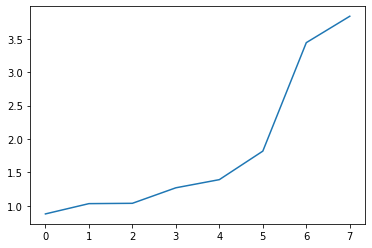

In [399]:
# plt.figure(figsize=(15,10))
plt.plot(rate_)

In [400]:
rate_

array([0.87706969, 1.031044  , 1.0359038 , 1.26828443, 1.39037433,
       1.81746457, 3.44191066, 3.8373056 ])

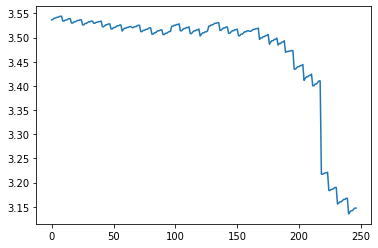

In [348]:
# plt.figure(figsize=(15,10))
plt.plot(recovery_volt)

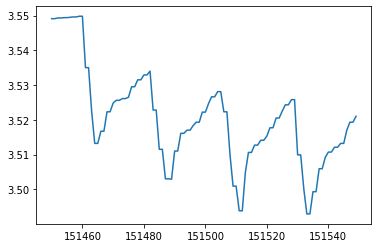

In [22]:
# plt.figure(figsize=(15,10))
plt.plot(data['Voltage(V)'][151450:151550])

In [118]:
recovery_rate[0]

array([0.59033537, 0.37387907])

In [78]:
date_=[] #replace korean to english

for i in recovery_time.flatten():
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)
    
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))
    
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)
    
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)
    
recovery_time = np.array(parsing_date).reshape(recovery_time.shape[0], 2)

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 5335.84it/s]


In [79]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

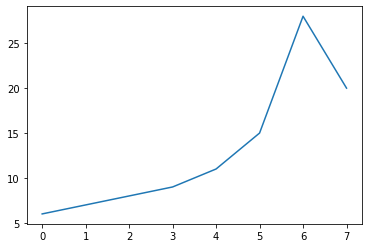

In [20]:
plt.plot(re_time) #통신 중 ~ 회복 전압

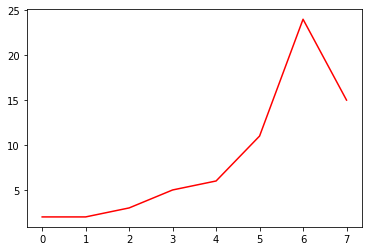

In [51]:
plt.plot(re_time, c="r") #통신 끝 ~ 회복 전압

In [18]:
mAh = np.array([], dtype=int)
current = 0

for i in tqdm(range(int(len(ref)/2))):
    current += 3800
    cap = current / 3600
    mAh = np.append(mAh, np.array(cap))

100%|████████████████████████████████████████████████████████████████████| 5266/5266 [00:00<00:00, 158923.62it/s]


In [19]:
mAh_ = mAh/8500 * 100 #21158

In [20]:
cap

5558.555555555556

In [21]:
mAh_[-1]

65.39477124183006

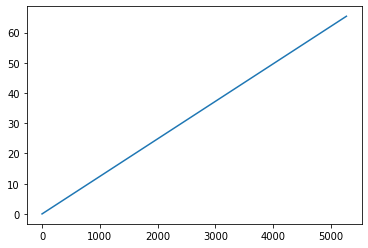

In [22]:
plt.plot(mAh_)

#### 전압 회복 시간 계산

In [25]:
re_time = np.array([])
for i in recovery_time:
    re_time = np.append(re_time, np.array((i[1]-i[0]).seconds))

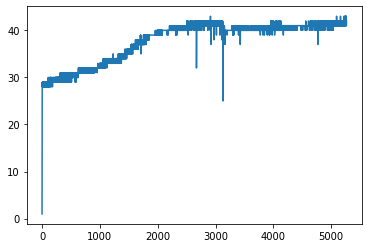

In [27]:
plt.plot(re_time) #통신 끝 ~ 회복 전압

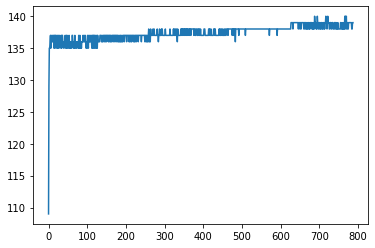

In [223]:
plt.plot(re_time) #기준 전압 ~ 회복 전압

*평균 전압 회복 시간*

In [224]:
np.average(re_time)

137.35152284263958

In [262]:
np.average(re_time)

29.911167512690355

#### 전압 회복 시간, 최대 전압 변화율 파일로 저장

In [185]:
max_rate = np.max(recovery_rate[:], axis=1)

In [204]:
f = open("NORMAL+EDLC(0-100-40).csv", "w")
f.write("recovery_time(s), max_rate\n")

for i in range(int(len(max_rate))):
    f.write(str(re_time[i]) + ", " + str(max_rate[i]) + "\n")
    
f.close()

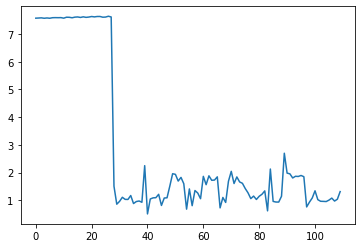

In [146]:
plt.plot(np.max(recovery_rate[600:], axis=1)) #627